In [1]:
# display all output and eliminate scrolling in output areas

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

<h2>Discovering Disease Outbreaks from News Headlings - Part 4</h2>

<b>Objective</b>

Identify pandemics by analyzing the centrally located headlines in the largest clusters of headlines. Look at the prevalence of disease in each cluster. Any disease outbreaks in the United States or around the world will be reported back to superiors at the WHO to direct help where it’s needed



<h3>I. Initial Steps</h3>

As first steps, before starting with the planned sections, we'll:
<ol>
<li>import the libraries to be used in this notebook</li>
<li>load the 'headlines' dataframe stored at the end of Part 2</li>
</ol>

In [3]:
# Initial Libraries
import numpy as np
import pandas as pd
import math
from math import cos, sin, asin
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import re

# this is only needed with certain combinations 
# of the Anaconda and Project environments on Windows
import os
os.environ['PROJ_LIB'] = 'C:/Anaconda3/Lib/site-packages/mpl_toolkits/basemap'

# this modules reduce 'distracting' warning outputs generated by Basemap
import warnings 
warnings.filterwarnings('ignore')

# loading Matplotlib.pyplot and Basemap
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# required for accessing city & country data from geonamescache
from unidecode import unidecode
from geonamescache import GeonamesCache
gc = GeonamesCache()



In [4]:
# Reading the dataframe produced at the end of Part 2 with columns
# containing the headline (text), city, country, latitude, longitude, and countrycode
df = pd.read_csv('data\df_headlines_complete_info_p2.txt', sep='|')
df.describe(include=object)
df.head()

,Headline,City,Country,CountryCode
count,611,611,15,611
unique,608,577,10,94
top,Barcelona Struck by Spanish Flu,Madrid,Brazil,US
freq,2,4,3,303


,Headline,City,Country,Latitude,Longitude,CountryCode
0,Zika Outbreak Hits Miami,Miami,NaN,25.77427,-80.19366,US
1,Could Zika Reach New York City?,New York City,NaN,40.71427,-74.00597,US
2,First Case of Zika in Miami Beach,Miami Beach,NaN,25.79065,-80.13005,US
3,"Mystery Virus Spreads in Recife, Brazil",Recife,Brazil,-8.05389,-34.88111,BR
4,Dallas man comes down with case of Zika,Dallas,NaN,32.78306,-96.80667,US


<h3>1. Separate the data into world and US datasets.</h3>

In Part 2, CountryCode's were added to the headlines dataframe. As indicated above, there are 611 CountryCodes in the df dataframe. That's one for each headline. Of these 94 are unique. Obviously, headlines from the US predominate, representing close to 50% (303 out of 611).

For the remainder of the analysis, the data will be divided into two segments -- the US and the rest of the world (labeled 'not_us'.

In [5]:
# segmenting data into US and rest of the world

df_us = df[df.CountryCode == 'US']
print('Dataframe df_us:')
print('{} Rows in df_us'.format(np.size(df_us,0)))
print('Sample of first 5 rows')
df_us.head()

df_not_us = df[df.CountryCode != 'US']
print('Dataframe df_not_us:')
print('{} Rows in df_not_us'.format(np.size(df_not_us,0)))
print('Sample of first 5 rows')
df_not_us.head()

Dataframe df_us:
303 Rows in df_us
Sample of first 5 rows


,Headline,City,Country,Latitude,Longitude,CountryCode
0,Zika Outbreak Hits Miami,Miami,NaN,25.77427,-80.19366,US
1,Could Zika Reach New York City?,New York City,NaN,40.71427,-74.00597,US
2,First Case of Zika in Miami Beach,Miami Beach,NaN,25.79065,-80.13005,US
4,Dallas man comes down with case of Zika,Dallas,NaN,32.78306,-96.80667,US
6,Zika Concerns are Spreading in Houston,Houston,NaN,29.76328,-95.36327,US


Dataframe df_not_us:
308 Rows in df_not_us
Sample of first 5 rows


,Headline,City,Country,Latitude,Longitude,CountryCode
3,"Mystery Virus Spreads in Recife, Brazil",Recife,Brazil,-8.05389,-34.88111,BR
5,Trinidad confirms first Zika case,Trinidad,NaN,-14.83333,-64.90000,BO
7,Geneve Scientists Battle to Find Cure,Geneve,NaN,46.20222,6.14569,CH
9,Zika Infested Monkeys in Sao Paulo,Sao Paulo,NaN,-23.54750,-46.63611,BR
12,San Juan reports 1st U.S. Zika-related death a...,San Juan,NaN,-31.53750,-68.53639,AR


<h3>2. Re-cluster the world and US data separately.</h3>
<ul>
    <li>Put your code into functions to quickly cluster and visualize results of the model.</li>
    <li>This may require different clustering parameters for each dataset.</li>
</ul>

<h4>2.1 Reclustering Function</h4>

In [6]:
# re-clustering based on DBSCAN - requires name of dataframe and eps
# min_samples = 3 and metric = great_circle_distance
# returns original dataframe new column 'Cluster' with outliers excluded

def re_cluster(input_df, eps):
    input_coord = input_df[['Latitude', 'Longitude']].values
    dbscan = DBSCAN(eps=eps, min_samples=3, 
                    metric=great_circle_distance)
    clusters = dbscan.fit_predict(input_coord)
    input_df = input_df.assign(Cluster=clusters)
    return input_df[input_df.Cluster > -1]

def great_circle_distance(coord1, coord2, radius=3956):
    if np.array_equal(coord1, coord2):
        return 0.0 
    coord1, coord2 = np.radians(coord1), np.radians(coord2)
    delta_x, delta_y = coord2 - coord1
    haversin = sin(delta_x / 2) ** 2 + np.product([cos(coord1[0]),
                                                   cos(coord2[0]), 
                                                   sin(delta_y / 2) ** 2])
    return  2 * radius * asin(haversin ** 0.5)

<h4> 2.2 Reclustering the world (not us) and US</h4>

The eps for the world (not_US) will remain at 250, while the eps for the US will be shorted to 125.

In [7]:
df_not_us = re_cluster(df_not_us, 250)
print('Dataframe df_not_us has {} unique clusters'.
     format(len(df_not_us.Cluster.value_counts())))

df_us = re_cluster(df_us, 125)
print('Dataframe df_us has {} unique clusters'.
     format(len(df_us.Cluster.value_counts())))

Dataframe df_not_us has 32 unique clusters
Dataframe df_us has 14 unique clusters


<h3>3. Sort the clusters by the number of headlines from largest to smallest.</h3>

<h4>3.1 Dividing the Dataframe into Groups with groupby</h4> 

First, both dataframes -- df_not_us and df_us -- are divided into groups by cluster. The resulting groups are stored in special 'groupby' dataframes (DataFrameGroupBy) -- labeled 'not_us_groups' and 'us_groups'. 

In [8]:
# for each set use 'groupby' to split its dataframe into groups based on cluster

not_us_groups = df_not_us.groupby('Cluster')
num_not_us_groups = len(not_us_groups)
print('{} clusters detected in {}'.format(num_not_us_groups,'not_us_groups'))

us_groups = df_us.groupby('Cluster')
num_us_groups = len(us_groups)
print('{} clusters detected in {}'.format(num_us_groups,'us_groups'))

32 clusters detected in not_us_groups
14 clusters detected in us_groups


<h4>Sorting Groups (of clusters) by Number of Headlines</h4>

Within both collections of groups - 'not_us_groups' and 'us_groups' - the cluster 'labels' are sorted by number of headlines. In turn the sorted results are stored in two separate lists - 'sorted_groups_not_us' and 'sorted_groups_us'. The distributions of clusters by number of headlines for each region are displayed below in bar charts.


Sorted cluster counts for not_us_groups:


<Figure size 432x288 with 0 Axes>

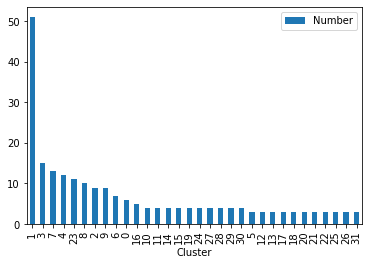


Sorted cluster counts for us clusters:


<Figure size 432x288 with 0 Axes>

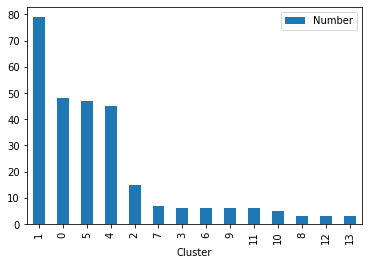

In [9]:
# sort the clusters in each collection of groups by number of Headlines

sorted_groups_not_us = sorted(not_us_groups, 
                              key=lambda x: len(x[1]),reverse=True)

sorted_groups_us = sorted(us_groups, 
                              key=lambda x: len(x[1]),reverse=True)

# plot sorted groups by number of clusters

def plot_sorted_groups(sorted_groups):
    sorted_tuples = []
    for group_id, df_group in sorted_groups:
        tup = (str(group_id),len(df_group))
        sorted_tuples.append(tup)
    df_sortcnts = pd.DataFrame(sorted_tuples, columns=['Cluster','Number'])

    plt.clf()
    df_sortcnts.plot('Cluster','Number',kind='bar')
    plt.show()

print('\nSorted cluster counts for not_us_groups:')
plot_sorted_groups(sorted_groups_not_us)

print('\nSorted cluster counts for us clusters:')
plot_sorted_groups(sorted_groups_us)

From these plots, it's easy to see that the distributions are skewed. Among the 'not_us' countries, the largest cluster is number 1 with 51 one headlines, while the largest cluster within the US is number 1 also with 79 headlines. 

<h3>4. Sort headlines within each cluster by finding headlines closest to the center of the cluster.</h3>
<ul>
    <li>You can average the location coordinates in each cluster to get an approximation of the center. If you want to be more accurate, then you’ll need to apply a geographic formula to find the true geographic center of each cluster.</li>
</ul>

<h4>4.1 Calculating the Distances from the Center.</h4>

<b>4.1.a Few Details about Groups sorted by Numbers of Headlines</b>

In <em>Section 3</em>, the headlines for the two regions - not-US and US - were divided into clusters which were then sorted from largest to smallest by number of headlines. The results were stored in 'sorted_groups_not_us' and 'sorted_groups_us', respectively.  Technically, each of these sorted_groups is a list of tuples of the form: 

    [(cluster_id1,dataframe_1), (cluster_id2,dataframe_2), ...,(cluster_idn,dataframe_n)] 

where each tuple consists of two objects - the cluster id and a dataframe whose rows consist of the headlines that belong to the cluster.

The following shows the details for one of these tuples along with the details for how to access the tuples and the associated cluster ids and dataframe.

In [10]:
# For the 'sorted_groups_not_us' there are 32 clusters and hence 32 tuples.
# To access the cluster with the tenth most headlines, we access the tuple 9, i.e. sorted_groups_not_us[9]
# To access the cluster id we specify the cluster and first tuple element 'sorted_groups_not_us[9][0]'
# To access the associated dataframe we specify the cluster and the second tuple element 'sorted_groups_not_us[9][1]'

print('Tuple in position 9:')
print(sorted_groups_not_us[9])

print('\nCluster:')
print(sorted_groups_not_us[9][0])

print('\nDataframe for Cluster:')
print(sorted_groups_not_us[9][1])

Tuple in position 9:
(0,                                        Headline         City Country  \
3       Mystery Virus Spreads in Recife, Brazil       Recife  Brazil   
192  More Zika patients reported in Joao Pessoa  Joao Pessoa     NaN   
284                       Zika arrives in Natal        Natal     NaN   
393                      Zika spreads to Olinda       Olinda     NaN   
456     More Zika patients reported in Custodia     Custodia     NaN   
520              Zika case reported in Limoeiro     Limoeiro     NaN   

     Latitude  Longitude CountryCode  Cluster  
3    -8.05389  -34.88111          BR        0  
192  -7.11500  -34.86306          BR        0  
284  -5.79500  -35.20944          BR        0  
393  -8.00889  -34.85528          BR        0  
456  -8.08750  -37.64306          BR        0  
520  -7.87472  -35.45028          BR        0  )

Cluster:
0

Dataframe for Cluster:
                                       Headline         City Country  \
3       Mystery Virus Spr

<b>4.1.b. Calculating the Center and Distance to Center</b>

To find the most important headlines for this cluster and for all the others, we need to:

<ol>
    <li>Calculate a center location for the clusters using the latitudes and longitudes of the headlines in the cluster</li>
    <li>Calculate the distance of each of the headlines from the center</li>
    <li>Store the results of these 'Distance_to_center' calculations in a new column in the cluster dataframe.</li>
</ol>
Once we've done this, we can then sort the headlines by the distance to the center to identify the most important.

Function for computing both center location of cluster and the distance of each headline in the cluster from the center.

In [11]:
def compute_centrality(group):
    group_coords = group[['Latitude', 'Longitude']].values 
    center = group_coords.mean(axis=0)
    distance_to_center = [great_circle_distance(center, coord)
                          for coord in group_coords]
    group['Distance_to_center'] = distance_to_center

Computing distances to center for 'not_us' clusters

In [12]:
for i in range(len(sorted_groups_not_us)):
    compute_centrality(sorted_groups_not_us[i][1])
    
for i in [10,31]:
    print('Sample dataframe for group {} containing cluster {} with column "Distance_to_Center" added:'
          .format(i,sorted_groups_not_us[i][0]))
    sorted_groups_not_us[i][1]

Sample dataframe for group 10 containing cluster 16 with column "Distance_to_Center" added:


,Headline,City,Country,Latitude,Longitude,CountryCode,Cluster,Distance_to_center
99,Malaria is Spreading in Johannesburg,Johannesburg,NaN,-26.20227,28.04363,ZA,16,58.948169
129,Johannesburg Patient in Critical Condition aft...,Johannesburg,NaN,-26.20227,28.04363,ZA,16,58.948169
316,Tuberculosis re-emerges in Silver Springs,Springs,NaN,-26.25000,28.40000,ZA,16,47.708149
346,Will Herpes vaccine help Newcastle?,Newcastle,NaN,-27.75796,29.93180,ZA,16,102.518783
588,Hepatitis C Outbreak in Bethlehem,Bethlehem,NaN,-28.23078,28.30707,ZA,16,91.079105


Sample dataframe for group 31 containing cluster 31 with column "Distance_to_Center" added:


,Headline,City,Country,Latitude,Longitude,CountryCode,Cluster,Distance_to_center
382,Huzhou Residents Receive Hepatitis B vaccine,Huzhou,NaN,30.87030,120.09330,CN,31,27.541568
590,Rumors about Swine Flu spreading in Suzhou hav...,Suzhou,NaN,31.30408,120.59538,CN,31,59.292306
596,Authorities are Worried about the Spread of He...,Yiwu,NaN,29.31506,120.07676,CN,31,82.267122


Computing distances to center for US clusters

In [13]:
for i in range(len(sorted_groups_us)):
    compute_centrality(sorted_groups_us[i][1])
    
for i in [7,13]:
    print('Sample dataframe for group {} containing cluster {} with column "Distance_to_Center" added:'
          .format(i,sorted_groups_us[i][0]))
    sorted_groups_us[i][1]

Sample dataframe for group 7 containing cluster 6 with column "Distance_to_Center" added:


,Headline,City,Country,Latitude,Longitude,CountryCode,Cluster,Distance_to_center
51,"Seattle scientists get $500,000 grant to pursu...",Seattle,NaN,47.60621,-122.33207,US,6,51.240204
304,Richland Center is infested with Hepatitis B,Richland,NaN,46.28569,-119.28446,US,6,119.589028
375,Kent is infested with Rabies,Kent,NaN,47.38093,-122.23484,US,6,38.975604
433,HIV has Arrived in Tacoma,Tacoma,NaN,47.25288,-122.44429,US,6,45.654203
464,The Spread of Dengue in Yakima has been Confirmed,Yakima,NaN,46.60207,-120.50590,US,6,59.097997
467,Rumors about Chlamydia spreading in Redmond ha...,Redmond,NaN,47.67399,-122.12151,US,6,47.651719


Sample dataframe for group 13 containing cluster 13 with column "Distance_to_Center" added:


,Headline,City,Country,Latitude,Longitude,CountryCode,Cluster,Distance_to_center
208,Will HIV vaccine help Las Vegas?,Las Vegas,NaN,36.17497,-115.13722,US,13,29.961529
287,How to Avoid Pneumonia in Bullhead City,Bullhead City,NaN,35.14778,-114.56830,US,13,47.854475
524,Respiratory Syncytial Virus Hits Henderson,Henderson,NaN,36.03970,-114.98194,US,13,18.067979


<h4>4.2 Sorting Headlines in Clusters by Distance to Center</h4>

A simple method (i.e. 'sort_values') is used to rank order the headlines in a cluster in terms of their distances to the center. Once the ranking has been done, we'll select the top 5 headlines in a cluster as the 'closest'. If a cluster has fewer than 5 headlines, we'll use all of them (recall that when we did the re-clustering we set 3 headlines as the minimum cluster size). Once sorted the 'top headlines' are printed for each of the clusters in the two regions (not-US and US).

Additionally, in this ranking process we create a list of the indexes of the top headlines for each segment. This will simplify the analysis that followings.

In addition to this ranking, we also decided to create a dictionary to hold the results of the process (that's why it looks a bit more complicated). This dictionary, which is labeled 'top_headlines_dict', includes entries for all the top clusters along with their headlines, cluster, distance_rank, and a blank entry for 'disease'. This latter entry will be used in the next sections to investigate the diseases discussed in the headline.

In [14]:
def sort_by_centrality(group):
    return group.sort_values('Distance_to_center', ascending=True)

def sort_headlines_by_cluster(sorted_groups):
    top_headline_ix_list = []
    for i in range(len(sorted_groups)):
        sorted_group = sort_by_centrality(sorted_groups[i][1])
        
        # collect list of headline indices in the original df dataframe
        if (len(sorted_group)) > 5: top_limit = 5
        else: top_limit = len(sorted_group)  
        top_headline_ix_list.extend(list(sorted_group.index[:top_limit]))
        
        clust = sorted_groups[i][0]
        print('\nHeadlines for group {} cluster {} sorted by "Distance to Center"'.format(i,clust))
        print(sorted_group.iloc[0:5,[0,7]])

    return top_headline_ix_list

In [15]:
# Ranking the headlines within a cluster by 'distance to the center' for the headlines in 'not_US' groups 
top_headlines_not_us_ix_list = sort_headlines_by_cluster(sorted_groups_not_us)


Headlines for group 0 cluster 1 sorted by "Distance to Center"
                                              Headline  Distance_to_center
392             Mad Cow Disease Disastrous to Brussels           78.796794
26             Scientists in Paris to look for answers           93.281422
232  More Livestock in Fontainebleau are infected w...          107.099376
267                     Mad Cow Disease Hits Rotterdam          152.419119
439  Contaminated Meat Brings Trouble for Bonn Farmers          156.539362

Headlines for group 1 cluster 3 sorted by "Distance to Center"
                                          Headline  Distance_to_center
96                Zika afflicts patient in Calamba           15.081487
38            Hepatitis E re-emerges in Santa Rosa           22.891972
128  Batangas Tourism Takes a Hit as Virus Spreads           23.880974
607          More Zika patients reported in Indang           29.603001
94                   Spreading Zika reaches Bacoor           37.779

Headlines for group 26 cluster 20 sorted by "Distance to Center"
                                              Headline  Distance_to_center
189                  Zika case recorded in Tunapuna Â»            3.714144
344  Laventille authorities confirmed the spread of...           10.917207
495  Sangre Grande Residents Recieve Gonorrhea vaccine           14.495571

Headlines for group 27 cluster 21 sorted by "Distance to Center"
                                 Headline  Distance_to_center
416                Zika arrives in Quezon           66.627880
197  More Zika patients reported in Davao           93.245506
455        Sulu, Zamboanga brace for Zika          151.614791

Headlines for group 28 cluster 22 sorted by "Distance to Center"
                              Headline  Distance_to_center
223      Vericella spreading in Ibadan           24.248617
521  Ibadan tests new cure for Malaria           24.248617
222      Varicella re-emerges in Lagos           48.508311

Headlines for grou

In [16]:
# Ranking the headlines within a cluster by 'distance to the center' for the headlines in 'US' groups
top_headlines_us_ix_list = sort_headlines_by_cluster(sorted_groups_us)


Headlines for group 0 cluster 1 sorted by "Distance to Center"
                                              Headline  Distance_to_center
410  Schools in Bridgeton Closed Due to Mumps Outbreak           33.822385
24                 Philadelphia experts track pandemic           39.182822
454  Vineland authorities confirmed the spread of C...           42.608266
21                      Baltimore plans for Zika virus           50.393591
336             Will Swine Flu vaccine help Annapolis?           59.872852

Headlines for group 1 cluster 0 sorted by "Distance to Center"
                                       Headline  Distance_to_center
423         Bradenton Experiences Zika Troubles           20.253212
58   New Zika Case Confirmed in Sarasota County           24.832389
19        Tampa Bay Area Zika Case Count Climbs           25.935667
242                 Zika Strikes St. Petersburg           27.386241
565                  Zika spreads to Plant City           29.682845

Headlines for

<h3>5. Examine the headlines closest to the center of each cluster. Record any repeated diseases in the headlines. Do this for both the US and the world data.</h3>
<ul>
    <li>If no diseases appear to be repeating, try the clustering again. Also make sure to look at enough headlines within each cluster to find repeated diseases.</li>
</ul>


<h4>5.1 In each region - not_us and US - which of the diseases appear repeatedly in the headlines?</h4>

<b>5.1.a List of Diseases</b>

Below is a list of the disease names that appear in all of the top 5 headlines for both regions (note: it was created manually). These names serve as keys for accessing the regex versions of the names that can be used for searching the top headlines.

In [17]:
import re

diseases = ['zika','mad cow','bronchitis','cholera','dengue','ebola','hepatitis b',
            'hepatitis c','hepatitis d','hepatitis e','hepititis a','herpes','hiv',
            'malaria','meningitis','norovirus','pneumonia','rabies','rotavirus',
            'spanish flu','swine flu','tuberculosis','varicella','vericella','west nile',
            'rhinovirus','mumps','syphilis','chikungunya','chlamydia','measles',
            'respiratory syncytial','gonorrhea']

disease_dict = {}
for disease in diseases:
    disease_dict[disease] = {}
    r_string = r"\b" + disease + r"\b"
    regex = re.compile(r_string, flags=re.IGNORECASE)
    disease_dict[disease]['regex'] = regex
    
print("Sample items from 'disease_dict'\n")
print('zika', disease_dict['zika'])
print('mad cow',disease_dict['mad cow'])

Sample items from 'disease_dict'

zika {'regex': re.compile('\\bzika\\b', re.IGNORECASE)}
mad cow {'regex': re.compile('\\bmad cow\\b', re.IGNORECASE)}


<b>5.1.b Frequency Distribution of Diseases in the Top Headlines</b>

In section 4.2 the indexes of all the top headlines for a given segment ('not_us' and 'US') were stored in a list (denoted by top_headlines_not_us_ix_list and top_headlines_us_ix_list, respectively). These lists simplify the process of retrieving the text of the associated headlines for each segment and determing which diseases occurred most frequently for each segment. 

In [18]:
from collections import Counter 

def disease_frequencies(top_headlines_indx_list, disease_dict):
    diseaseCnt =  Counter()
    for indx in top_headlines_indx_list:
        headline = df.iloc[indx,0]
        for disease in diseases:
            disease_regex = disease_dict[disease]['regex']
            if disease_regex.search(headline):
                diseaseCnt[disease] += 1
                break
    return diseaseCnt

In [19]:
def plot_sorted_cnts(sorted_tuples):
    df_sortcnts = pd.DataFrame(sorted_tuples, columns=['Disease','Frequency'])
    plt.clf()
    df_sortcnts.plot('Disease','Frequency',kind='bar')
    plt.show()


Diseases in Top Headlines for not_US Clusters:
26 Unique Diseases specified in 121 out of Top 128 Headlines

Frequencies by Disease for not_US Headlines:
 [('zika', 67), ('west nile', 4), ('malaria', 4), ('rotavirus', 4), ('mad cow', 3), ('spanish flu', 3), ('rabies', 3), ('norovirus', 3), ('swine flu', 3), ('hepatitis e', 2), ('hepatitis c', 2), ('pneumonia', 2), ('dengue', 2), ('varicella', 2), ('tuberculosis', 2), ('herpes', 2), ('bronchitis', 2), ('meningitis', 2), ('hepatitis b', 2), ('cholera', 1), ('ebola', 1), ('hepatitis d', 1), ('rhinovirus', 1), ('gonorrhea', 1), ('vericella', 1), ('hiv', 1)]

Plot of Frequencies by Disease for not_US Headlines:


<Figure size 432x288 with 0 Axes>

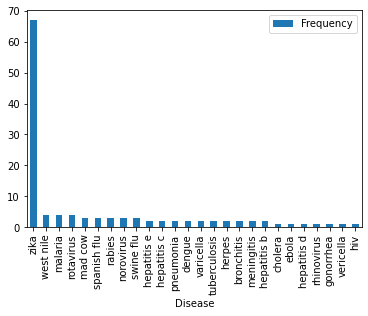

In [20]:
# Counters for Diseases in not_US Headlines
not_US_disease_freq = disease_frequencies(top_headlines_not_us_ix_list, disease_dict)
most_common_not_US = not_US_disease_freq.most_common(len(not_US_disease_freq))

num_headlines = len(top_headlines_not_us_ix_list)
uniq_cnts = len(not_US_disease_freq)
sum_cnts = sum(not_US_disease_freq.values())
miss_heads = num_headlines-sum_cnts

print('\nDiseases in Top Headlines for not_US Clusters:')
print('{} Unique Diseases specified in {} out of Top {} Headlines'
      .format(uniq_cnts,sum_cnts,num_headlines))
print('\nFrequencies by Disease for not_US Headlines:\n',most_common_not_US)
print('\nPlot of Frequencies by Disease for not_US Headlines:')
plot_sorted_cnts(most_common_not_US)


Diseases in Top Headlines for US Clusters:
21 Unique Diseases specified in 62 out of Top 64 Headlines

Frequencies by Disease for US Headlines:
 [('zika', 20), ('syphilis', 4), ('respiratory syncytial', 4), ('pneumonia', 4), ('mumps', 3), ('rotavirus', 3), ('hiv', 3), ('chlamydia', 2), ('swine flu', 2), ('west nile', 2), ('hepatitis e', 2), ('hepatitis c', 2), ('chikungunya', 2), ('hepatitis b', 2), ('rhinovirus', 1), ('rabies', 1), ('dengue', 1), ('measles', 1), ('hepatitis d', 1), ('herpes', 1), ('gonorrhea', 1)]

Plot of Frequencies by Disease for US Headlines:


<Figure size 432x288 with 0 Axes>

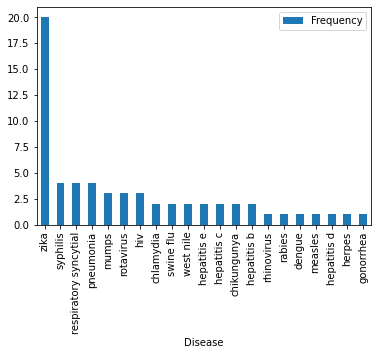

In [21]:
# Counters for Diseases in US Headlines
US_disease_freq = disease_frequencies(top_headlines_us_ix_list, disease_dict)
most_common_US = US_disease_freq.most_common(len(US_disease_freq))

num_headlines = len(top_headlines_us_ix_list)
uniq_cnts = len(US_disease_freq)
sum_cnts = sum(US_disease_freq.values())
miss_heads = num_headlines-sum_cnts

print('\nDiseases in Top Headlines for US Clusters:')
print('{} Unique Diseases specified in {} out of Top {} Headlines'
      .format(uniq_cnts,sum_cnts,num_headlines))
print('\nFrequencies by Disease for US Headlines:\n',most_common_US)
print('\nPlot of Frequencies by Disease for US Headlines:')
plot_sorted_cnts(most_common_US)

Looking at the above bar charts it is easy to see that 'Zika' appears in a substantially larger percentage of the headlines in both the non-US and US segments. The closest disease to Zika is Rotavirus with a combined total of 7 of the top headlines (which isn't even a tenth of the combined Zika total of 87 of the top headlines). For this reason, in Section 6 we'll only concentrate on Zika, although the functions have been set up to handle other diseases.  

<h3>6. Pinpoint disease outbreaks based on repeated diseases within headlines in clusters. Prepare final maps of the United States and the world.</h3>
<ul>
    <li>If you find one or two major diseases, you can find all mentions of it in headlines using regular expressions.</li>
    <li>Remove any irrelevant headlines from the map for presentation.</li>
</ul>

<h4>Introducing the Zika Virus</h4>

The Zika was first discovered in 1947 in the Zika Forest of Uganda. Zika is primarily transmitted thru mosquito bites from the Aedes species, although it is also transmitted thru sex and from the mother to an unborn child. The first human cases were reported in 1952. Since that time major outbreaks have occurred Africa, Southeast Asia, the Pacific Islands, parts of the United States primarily in the southern border states and in the US Territories (especially Puerto Rico).  

In 2016 there was a major outbreak in the US with 5182 reported cases with large pockets in FL(1107), NY(1000) and TX(312). The vast majority of these (4897) were cases where travelers infected in other areas of the world, 224 where from local mosquito bites, and the rest 47 were from other sources.  That year among the US Territories (primarily Puerto Rico) had 36,512 cases of which 36,372 were from local mosquitos. By 2017, the number of cases in the US dropped to 452 with 432 of these brought by travelers returning to the US. Similarly, the number in the US Territories dropped to 666 cases with all but 1 coming from local mosquito bites. In 2019 the number of US cases was 22 and the US Territories was 71. Since then, there have been no reported cases in the greater US area.

<h4>6.1 World wide and US Clusters with Zika Outbreaks</h4>

The maps that follow highlight those clusters in the rest of the world, in the US, and in both combined where 50% of the headlines mention Zika. While there are no dates provided, the patterns in the maps below (6.1.a for rest of the world, 6.1.b for the US and 6.1.c for the combination of the two) follow slightly different patterns. 

In [22]:
def count_disease_mentions(headlines,disease_name,d=disease_dict):   
    disease_regex = d[disease_name]['regex']
    disease_count = 0
    for headline in headlines:
        if disease_regex.search(headline): 
            disease_count += 1
    return disease_count

# Mapping of Clusters mentioning Zika in not_US Headlines
def plotting_disease(disease_name, sorted_groups, region):
    if region != 'US':
    # plotting rest of world or combined
        fig = plt.figure(figsize=(15, 15))
        map_plotter = Basemap()
        for _, group in sorted_groups:
            headlines = group.Headline.values
            disease_count = count_disease_mentions(headlines,disease_name)
            if float(disease_count) / len(headlines) > 0.5:
                map_plotter.scatter(group.Longitude.values, 
                                    group.Latitude.values,
                                    latlon=True)
        map_plotter.drawcoastlines()
        plt.show()
        
    else: # plotting US    
        fig = plt.figure(figsize=(12, 10))
        map_lcc = Basemap(projection='lcc', llcrnrlon=-119,
                          llcrnrlat=22, urcrnrlon=-64, urcrnrlat=49,
                           lat_1=33, lat_2=45, lon_0=-95)

        for _, group in sorted_groups:
            headlines = group.Headline.values
            disease_count = count_disease_mentions(headlines,disease_name)
            if float(disease_count) / len(headlines) > 0.5:
                map_lcc.scatter(group.Longitude.values, 
                                    group.Latitude.values,
                                    latlon=True)
        map_lcc.drawcoastlines()
        map_lcc.drawstates()
        plt.show()

<h5>6.1.a Map of cluster headlines in the 'not_us' mentioning Zika</h5>

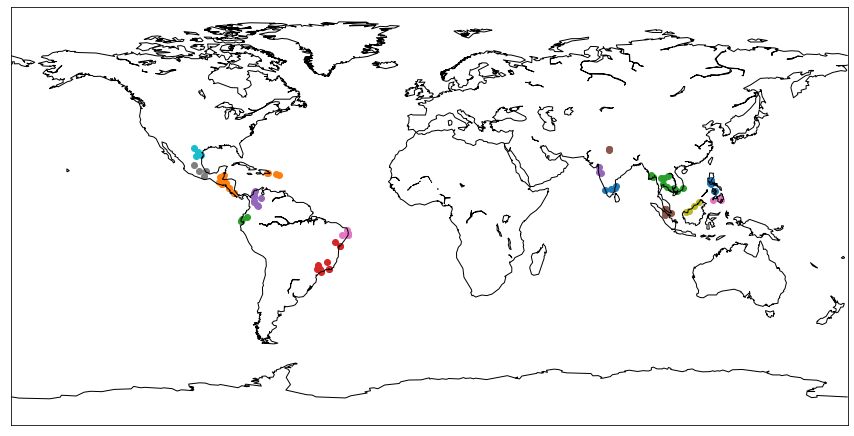

In [23]:
# Plotting Zika for Rest of World - sorted_groups_not_us

plotting_disease('zika',sorted_groups_not_us,'not US')

Based on the headlines for the rest of the world, the strongest pockets are found in Latin America (including Mexico, Central America, and the islands of the Caribbean), India and Southeast  Asia. The major surprise is the lack headlines in Africa, although there are also few articles from Africa throughout the entire sample of 611 headlines.

<h5>6.1.b Map of cluster headlines in the 'US' mentioning Zika</h5>

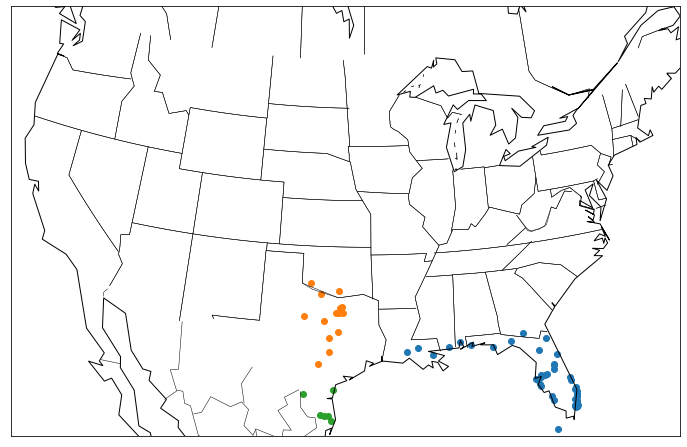

In [24]:
# Plotting Zika for Rest of World - sorted_groups_not_us

plotting_disease('zika',sorted_groups_us,'US')

With the US, the pattern is not quite as spread out as the patterns in 2015-2017. More specifically, the headlines seem to be spread across the Gulf states with a cluster of headlines also running from around Austin to just above Dallas.

<h5>6.1.c Map of cluster headlines in both the US and the 'non_US' mentioning Zika</h5>

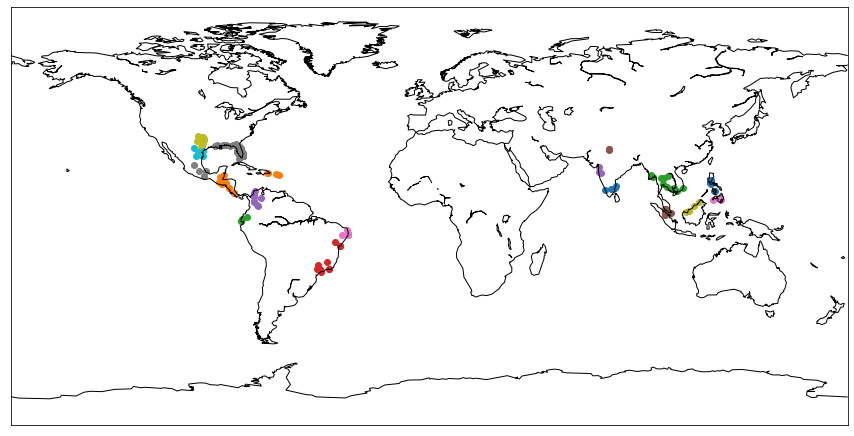

In [25]:
# Plotting Zika for combined regions

sorted_groups = sorted_groups_not_us + sorted_groups_us
plotting_disease('zika',sorted_groups,'Combined')

This map just combines the results for the rest of the world and the US. 